# Поиск компонентов сильной связности в графе, алгоритм Косарайю 

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt

## 1. Реализация через представление графа в виде векторов смежности

### Дополнительные структуры данных

In [2]:
class MyQueue:
    
    def __init__(self):
        self.queue = []
        
    def put(self, element):
        self.queue.append(element)
        
    def get(self):
        if not self.is_empty():
            return self.queue.pop(0)
        else:
            raise KeyError
            
    def is_empty(self):
        return not self.queue
        
    def is_in_queue(self, element):
        return element in self.queue
    
    
class MyDeque(MyQueue):
    
    def pop_left(self):
        super().get()
        
    def pop_right(self):
        if not self.is_empty():
            return self.queue.pop(-1)
        else:
            raise KeyError

### Алгоритм Косарайю

- возвращает массив, где в ячейке с индексом номера вершины находится номер группы компонентов сильной связности, в которую данная вершина входит

In [3]:
def inverted_adjacency_vectors(vectors):
    vectors_inverted = [[] for i in range (len(vectors))]
    for node_src, edges in enumerate(vectors):
        for node_dest in edges:
            if node_dest is not None:
                vectors_inverted[node_dest].append(node_src)
            else:
                break
    return vectors_inverted


def DFS_Kosaraju_inverted_adjacency_vectors(graph, node, processed, deque):
    processed.add(node)
    for node_dest in graph[node]:
        if node_dest not in processed:
            DFS_Kosaraju_inverted_adjacency_vectors(graph, node_dest, processed, deque)
    if not deque.is_in_queue(node):
        deque.put(node)
        

def DFS_Kosaraju_adjacency_vectors(graph, node, component_index, result):
    result[node] = component_index
    for node_dest in graph[node]:
        if result[node_dest] is None:
            DFS_Kosaraju_adjacency_vectors(graph, node_dest, component_index, result)
            

def Kosaraju_adjacency_vectors(graph):
    inverted_graph = inverted_adjacency_vectors(graph)
    processed = set()
    deque = MyDeque()
    for node in range(len(inverted_graph)):
        if node not in processed:
            DFS_Kosaraju_inverted_adjacency_vectors(inverted_graph, node, processed, deque)  
    result = [None for i in range(len(graph))]
    component_index = 1
    while not deque.is_empty():
        node = deque.pop_right()
        if result[node] is None:
            DFS_Kosaraju_adjacency_vectors(graph, node, component_index, result)
            component_index += 1
    return result

## 2. Реализация через представление графа в виде класса

### Реализация графа через класс

In [28]:
class Node:
    
    def __init__(self, label):
        self.label = label
        self.edges = []
        
    def add_edge(self, node, weight):
        if not self.edges:
            self.edges.append(Edge(node, weight))
        else:
            for edge in self.edges:
                if edge.node == node:
                    raise ValueError(f'Edge "{self.label}-->{node.label}" already exists.')
            self.edges.append(Edge(node, weight))
            self.edges.sort(key=lambda edge: edge.node.label)

    def get_edges(self):
        return self.edges
    
    def __str__(self):
        res = []
        for edge in self.edges:
            res.append(f'{self.label}-->{edge.node.label}({edge.weight})')
        return(', '.join(res))
    
    
class Edge:
    
    def __init__(self, node, weight):
        self.node = node
        self.weight = weight
        
        
class Graph:
    
    def __init__(self):
        self.nodes = {}
        
    def add_node(self, label):
        if label not in self.nodes:
            self.nodes[label] = Node(label)
        else:
            raise ValueError(f'Node {node.label} is already in graph.')
            
    def get_nodes(self):
        return self.nodes
    
    def get_node(self, label):
        return self.nodes[label]
    
    @classmethod
    def from_adjacency_vectors(cls, vectors):
        instance = cls()
        labels = [i for i in range(len(vectors))]
        for label in labels:
            instance.add_node(label)
        for label_src, row in zip(labels, vectors):
            for label_dest in row:
                if label_dest is not None:
                    instance.get_node(label_src).add_edge(instance.get_node(label_dest), 0)
                else:
                    break
        return instance
    
    def __str__(self):
        res = []
        for k, node in self.nodes.items():
            res.append(str(node))
        return '\n'.join(res)
    
    @classmethod
    def inverted(cls, graph):
        self_inverted = cls()
        for label in graph.nodes:
            self_inverted.add_node(label)
        for _, node_src in graph.nodes.items():
            for edge in node_src.edges:
                self_inverted.nodes[edge.node.label].add_edge(self_inverted.get_node(node_src.label), edge.weight)
        return self_inverted

### Алгоритм Косарайю

- генерирует массивы с компонентами сильной связности

In [29]:
def DFS_Kosaraju_inverted(node, processed, deque):
    processed.add(node.label)
    for edge in node.edges:
        if edge.node.label not in processed:
            DFS_Kosaraju_inverted(edge.node, processed, deque)
    if not deque.is_in_queue(node.label):
        deque.put(node.label)

        
def DFS_Kosaraju(node, components, processed):
    processed.add(node.label)
    components.append(node.label)
    for edge in node.edges:
        if edge.node.label not in components and edge.node.label not in processed:
            DFS_Kosaraju(edge.node, components, processed)

            
def Kosaraju(G):
    processed = set()
    deque = MyDeque()
    H = Graph.inverted(G)
    for label, node in H.nodes.items():
        if label not in processed:
            DFS_Kosaraju_inverted(node, processed, deque)
    processed = set()
    while not deque.is_empty():
        node = G.get_node(deque.pop_right())
        if node.label not in processed:
            processed.add(node.label)
            components = []
            DFS_Kosaraju(node, components, processed)
            yield components

## 3. Проверка корректности работы реализаций алгоритма

### На примере графа из слайдов к лекции

In [30]:
# для перевода массива с номерами компонентов в массив массивов с компонентами
def to_list_of_lists(array):
    result = [[] for i in range(max(array))]
    for node in range(len(array)):
        result[array[node]-1].append(node)
    return sorted(result) 

In [31]:
vectors = [
    [1],        # 0 - A
    [5, 2, 4],  # 1 - B
    [6, 3],     # 2 - C
    [2, 7],     # 3 - D
    [0, 5],     # 4 - E
    [6],        # 5 - F
    [5],        # 6 - G
    [6, 3],     # 7 - H
]

#### Готовая библиотека NetworkX

In [32]:
G = nx.DiGraph()
for node_src, nodes_dest in enumerate(vectors):
    for node_dest in nodes_dest:
        G.add_edge(node_src, node_dest)

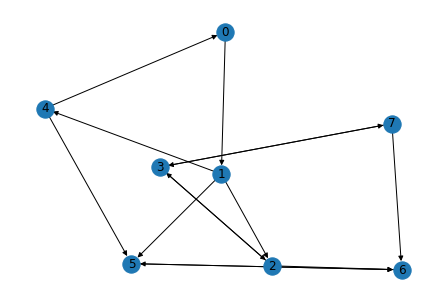

In [33]:
nx.draw(G, with_labels=True)
plt.show()

In [34]:
result_nx = nx.algorithms.components.kosaraju_strongly_connected_components(G)
result_nx = sorted([sorted(list(element)) for element in result_nx])
print(result_nx)

[[0, 1, 4], [2, 3, 7], [5, 6]]


#### Векторы смежности

In [35]:
result_adjacency_vectors = Kosaraju_adjacency_vectors(vectors)
result_adjacency_vectors = to_list_of_lists(result_adjacency_vectors)
print(result_adjacency_vectors)

[[0, 1, 4], [2, 3, 7], [5, 6]]


#### Класс

In [36]:
G = Graph.from_adjacency_vectors(vectors)
result_class = Kosaraju(G)
result_class = sorted([sorted(element) for element in result_class])
print(result_class)

[[0, 1, 4], [2, 3, 7], [5, 6]]


### На примере случайно сгенерированного графа

In [37]:
def generate_adjacency_vectors(N, max_degree):
    vectors = []
    for i in range(N):
        nodes = []
        available_nodes = [x for x in range(N) if x != i]
        for j in range(random.randint(0, max_degree)):
            node = available_nodes.pop(random.randint(0, len(available_nodes)-1))
            nodes.append(node)
        vectors.append(nodes)
    return vectors

In [38]:
vectors = generate_adjacency_vectors(1000, 4)

#### Готовая библиотека NetworkX

In [39]:
G = nx.DiGraph()
for node_src, nodes_dest in enumerate(vectors):
    G.add_node(node_src)
    for node_dest in nodes_dest:
        G.add_edge(node_src, node_dest)

In [40]:
result_nx = nx.algorithms.components.kosaraju_strongly_connected_components(G)
result_nx = sorted([sorted(list(element)) for element in result_nx])

In [41]:
[len(group) for group in result_nx if len(group) > 1]

[564]

#### Векторы смежности

In [42]:
result_adjacency_vectors = Kosaraju_adjacency_vectors(vectors)
result_adjacency_vectors = to_list_of_lists(result_adjacency_vectors)
print(result_adjacency_vectors == result_nx)

True


#### Класс

In [43]:
G = Graph.from_adjacency_vectors(vectors)
result_class = Kosaraju(G)
result_class = sorted([sorted(element) for element in result_class])
print(result_class == result_nx)

True


### 4. Сравнение времени выполнения алгоритма

In [44]:
N = 3000
max_degree = 50

#### Векторы смежности

In [45]:
%%timeit -r 3 -n 3 -o -q
vectors = generate_adjacency_vectors(N, max_degree)
result_adjacency_vectors = Kosaraju_adjacency_vectors(vectors)
result_adjacency_vectors = to_list_of_lists(result_adjacency_vectors)

<TimeitResult : 486 ms ± 4.57 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)>

#### Класс

In [50]:
%%timeit -r 3 -n 3 -o -q
vectors = generate_adjacency_vectors(N, max_degree)
G = Graph.from_adjacency_vectors(vectors)
result_class = list(Kosaraju(G))
result_class = sorted([sorted(element) for element in result_class])

<TimeitResult : 2.02 s ± 34.6 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)>

#### Готовая библиотека NetworkX

In [47]:
%%timeit -r 3 -n 3 -o -q
vectors = generate_adjacency_vectors(N, max_degree)
G = nx.DiGraph()
for node_src, nodes_dest in enumerate(vectors):
    G.add_node(node_src)
    for node_dest in nodes_dest:
        G.add_edge(node_src, node_dest)
result_nx = nx.algorithms.components.kosaraju_strongly_connected_components(G)
result_nx = sorted([sorted(list(element)) for element in result_nx])

<TimeitResult : 557 ms ± 2.59 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)>